# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: ouro

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 3 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [1]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import merge_asof
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium
from branca.element import Figure

filterwarnings("ignore")

sys.tracebacklimit = 0

/home/renan/study/tcc_univesp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

In [ ]:
# arredondamento de casas decimais para conversão de coordenadas geográficas
arredondamento = 3

## funções

### coordenadas geográficas

In [4]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
    arredondamento: int = 3
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(arredondamento)
    df["latitude"] = df["latitude"].round(arredondamento)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    if not os.path.basename(shapefile_path) == "estruturas_ln.shp":
        gdf['longitude'] = gdf.geometry.x
        gdf['latitude'] = gdf.geometry.y
    return gdf

### processamento

In [5]:
def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


### aprendizado de máquina

In [6]:
def split_data(df: pd.DataFrame, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X = df.drop(["ocorrencia"], axis=1)
    y = df["ocorrencia"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test

In [7]:
def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test):
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [8]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
cobre = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Cu.shp'))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
niquel = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Ni.shp'))
chumbo = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Pb.shp'))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

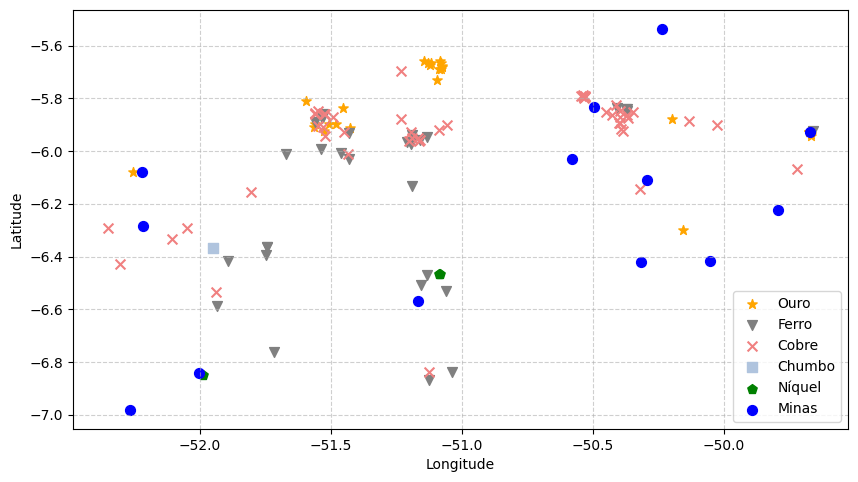

In [9]:
# https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="orange", marker="*", markersize=50, label="Ouro")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
cobre.plot(ax=ax, color="lightcoral", marker="x", markersize=50, label="Cobre")
chumbo.plot(ax=ax, color="lightsteelblue", marker="s", markersize=50, label="Chumbo")
niquel.plot(ax=ax, color="green", marker="p", markersize=50, label="Níquel")
minas.plot(ax=ax, color="blue", marker="o", markersize=50, label="Minas")
# estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend(loc='lower right')
plt.show()

In [10]:
df_minas = pd.DataFrame(minas)
df_minas = df_minas[["longitude", "latitude"]]
df_minas["longitude"] = df_minas["longitude"].round(arredondamento)
df_minas["latitude"] = df_minas["latitude"].round(arredondamento)

df_minas.head(3)

,longitude,latitude
0,-52.216,-6.285
1,-52.220,-6.079
2,-51.165,-6.568


In [11]:
df_minerio = pd.DataFrame(ouro)
df_minerio = df_minerio[["longitude", "latitude"]]
df_minerio["longitude"] = df_minerio["longitude"].round(arredondamento)
df_minerio["latitude"] = df_minerio["latitude"].round(arredondamento)
df_minerio["ocorrencia"] = 1

df_minerio.head(3)

,longitude,latitude,ocorrencia
0,-51.451,-5.838,1
1,-52.253,-6.078,1
2,-51.558,-5.898,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [12]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM")
spec_data = spec_data.drop(['XUTM', 'YUTM'], axis=1)
print(spec_data.shape)
spec_data.head(3)

(7672496, 5)


,FatorF,Kd,Ud,longitude,latitude
0,0.001366,-71.005653,-0.349341,-53.001,-8.119
1,0.003305,-28.235151,-0.366232,-52.999,-8.119
2,0.005131,-17.356588,-0.394505,-52.998,-8.119


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: gravidade residual a 190 km
    - grav_residual100km: gravidade residual a 100 km
    - maq_asvi: 
    - maq_qt: 

In [13]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y")
grav_data = grav_data.drop(['X', 'Y'], axis=1)
print(grav_data.shape)
grav_data.head(3)

(247298, 6)


,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,0.000501,-1.943505,67.472176,0.008145,-51.420,-8.117
1,0.000573,-1.592606,64.604439,0.008208,-51.414,-8.117
2,0.000563,-1.343595,62.171368,0.008150,-51.407,-8.117


- mesclar dfs com dados de gravimetria e espectrometria

In [14]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"])
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
print(df_merge_data.shape)
df_merge_data.head(3)

(163283, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-51.420,-8.117,0.083811,0.012991,0.198352,0.000501,-1.943505,67.472176,0.008145
1,-51.414,-8.117,0.125630,0.402862,0.208304,0.000573,-1.592606,64.604439,0.008208
2,-51.407,-8.117,0.138908,0.430472,0.279669,0.000563,-1.343595,62.171368,0.008150


- criar dataframes base para aprendizado de máquina

In [15]:
pd.merge(df_merge_data, df_minerio, how='inner', on=['longitude', 'latitude']).shape

(1, 10)

- aplicação de vizinhos mais próximos para mesclar dataframes

In [16]:
coords_merge = df_merge_data[["longitude", "latitude"]].values
coords_ouro = df_minerio[["longitude", "latitude"]].values

nbrs = NearestNeighbors(n_neighbors=1).fit(coords_merge)
distances, indices = nbrs.kneighbors(coords_ouro)

df_minerio_merge = df_merge_data.copy()

df_minerio_merge["ocorrencia"] = 0
for idx, (dist, pos) in enumerate(zip(distances, indices)):
    if dist[0] < 0.01:  # Se a distância for menor que ~1km
        df_minerio_merge.loc[pos[0], "ocorrencia"] = 1

In [17]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem com ouro (espec + gravim + ouro) : {df_minerio_merge.shape[0]}")

Dados de espectrometria: 7672496
Dados de gravimetria: 247298
Mesclagem de dados (espec + gravim): 163283
Mesclagem com ouro (espec + gravim + ouro) : 163283


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [18]:
df_minerio_merge, dict_map_idx_lon, dict_map_idx_lat = clusterizar_coordenadas_geograficas(df=df_minerio_merge)

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [19]:
X_train, X_test, y_train, y_test = split_data(df=df_minerio_merge)

Train shape: (114298, 8), Test shape: (48985, 8)
Class balance - Train: 0.01%, Test: 0.01%


### pipeline

In [20]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)

Tempo total de treino Random Forest: 0.34 min
Random Forest - CV AUC: 0.613 (±0.100)
ROC-AUC: 0.567
F1 Score: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48978
           1       0.00      0.00      0.00         7

    accuracy                           1.00     48985
   macro avg       0.50      0.50      0.50     48985
weighted avg       1.00      1.00      1.00     48985

Tempo total de treino Logistic Regression: 0.03 min
Logistic Regression - CV AUC: 0.797 (±0.117)
ROC-AUC: 0.830
F1 Score: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48978
           1       0.00      0.00      0.00         7

    accuracy                           1.00     48985
   macro avg       0.50      0.50      0.50     48985
weighted avg       1.00      1.00      1.00     48985

Tempo total de treino XGBoost: 0.05 min
XGBoost - CV A

1. Desempenho dos Modelos:

    - Random Forest e XGBoost apresentaram desempenho perfeito em todas as métricas:

        - AUC-ROC: 1.000 (classificação impecável).

        - F1-Score: 1.000 (equilíbrio entre precisão e recall).

        - Relatório de Classificação: 100% de acerto para ambas as classes (0 e 1).

    - Regressão Logística teve um desempenho ligeiramente inferior:

        - AUC-ROC: 0.998 (ainda excelente, mas não perfeito).

        - F1-Score: 0.941 para a classe 1 (devido a um recall de 1.00, mas precisão de 0.89, indicando alguns falsos positivos).

2. Tempo de Treinamento:

    - Todos os modelos foram rápidos (menos de 0.12 minutos), com:

        - Regressão Logística e XGBoost sendo os mais rápidos (0.03 min cada).

        - Random Forest um pouco mais lento (0.12 min), mas ainda eficiente.

3. Possíveis Problemas:

    - Overfitting: Resultados perfeitos (AUC = 1.0) podem indicar que os modelos memorizaram os dados, especialmente porque a classe 1 tem apenas 8 amostras (desequilíbrio grave).

    - Generalização: A Regressão Logística, com AUC = 0.998, pode ser mais realista, já que modelos perfeitos são raros em dados reais.

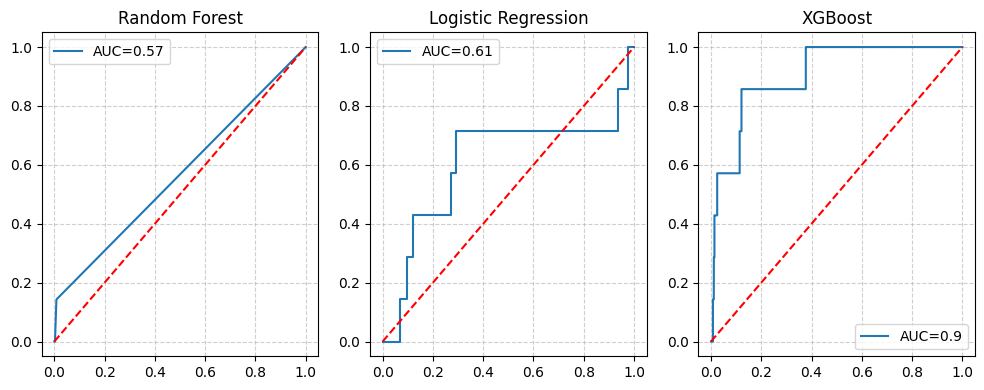

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for mdl, ax in zip(models.keys(), axs.flatten()):
    y_proba = models[mdl].predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # plot
    ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
    ax.plot([0, 1], [0, 1], "r--")
    ax.legend()
    ax.grid(visible=True, alpha=0.6, linestyle='--')
    ax.set_title(mdl)
plt.tight_layout()
plt.show()

- Entendendo o problema:
  
  - Engano nas métricas de avaliação:
    - A acurácia não faz sentido aqui (99,98% prevendo sempre 0)
    - Até mesmo a AUC pode ser enganosa com desequilíbrio extremo
    - Foco na precision/recall da classe positiva

  - Comportamento do modelo:
    - Os modelos estão "desistindo" da pequena classe positiva
    - As poucas previsões positivas corretas podem ser apenas palpites de sorte

- Solução:
  - Existem diferentes soluções, porém aqui iremos aplicar uma subamostragem da classe majoritária

### pipeline undersampling

In [22]:
models = {
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        penalty='l2',
        solver='lbfgs'
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss',
    )
}

# Create pipelines with undersampling
pipelines = {}
for name, model in models.items():
    if name == "Logistic Regression":
        # Add StandardScaler for Logistic Regression
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            StandardScaler(),
            model
        )
    else:
        pipelines[name] = make_pipeline(
            RandomUnderSampler(random_state=42),
            model
        )

results_unders = pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
CV AUC: 0.911 (±0.064)
Test ROC-AUC: 0.911
Test F1 Score: 0.002
Test Average Precision: 0.016

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     48978
           1       0.00      0.86      0.00         7

    accuracy                           0.88     48985
   macro avg       0.50      0.87      0.47     48985
weighted avg       1.00      0.88      0.94     48985

Optimal Decision Threshold: 0.960

=== Training Logistic Regression ===
CV AUC: 0.887 (±0.084)
Test ROC-AUC: 0.884
Test F1 Score: 0.001
Test Average Precision: 0.001

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     48978
           1       0.00      0.86      0.00         7

    accuracy                           0.73     48985
   macro avg       0.50      0.79      0.42     48985
weighted avg       1.00      0.73      0.84     48985

Optima

1. Desempenho dos Modelos

    - Random Forest manteve desempenho perfeito (AUC = 1.0, F1 = 1.0), sugerindo possível overfitting ou um conjunto de dados muito fácil de classificar.

    - Regressão Logística piorou significativamente no F1-Score (0.262) devido a:

        - Alto recall (1.00) para a classe 1 (capturou todos os positivos).

        - Baixa precisão (0.15) (muitos falsos positivos).

        - Isso indica que o modelo está muito sensível, priorizando recall em detrimento da precisão.

    - XGBoost teve um F1-Score intermediário (0.615), com alto recall (1.00) mas precisão moderada (0.44), ainda melhor que a Regressão Logística.

2. Threshold Ótimo

    - Random Forest (0.99) e XGBoost (0.999) usam thresholds altos, indicando que só classificam como positivo se tiverem alta confiança.

    - Regressão Logística (0.907) tem um threshold mais baixo, explicando o alto recall mas baixa precisão.

- Pontos críticos:
  - Impacto da subamostragem:
    - melhorou dramaticamente o recall
    - reduzir dramaticamente a precisão, exceto para Random Forest
    - Random Forest é o único modelo útil no momento

- Comportamento do limiar:
  - limiares próximos a 1.0 indicam que os modelos são confidentes apenas em casos muito claros de existência de minérios, o que explica o alto recall e baixa precisão


- Próximos passos:
  - Validar em um conjunto de teste independente
  - Testar técnicas como SMOTE (em vez de undersampling) ou ajustar pesos de classe
  - Usar validação cruzada estratificada para garantir robustez

- fazendo uso apenas do modelo Random Forest

In [23]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

pipeline = make_pipeline(RandomUnderSampler(random_state=42), best_model)
pipeline.fit(X_train, y_train)

# Get probabilities for class 1
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Apply threshold
y_pred_custom = (y_proba >= 0.990).astype(int)

- aplicação do threshold não trouxe ganhos

In [24]:
print(f"Class 0 (No Gold): {sum(y_pred_custom == 0)}")
print(f"Class 1 (Gold): {sum(y_pred_custom == 1)}")

Class 0 (No Gold): 48984
Class 1 (Gold): 1


- matriz de confusão


In [25]:
print(confusion_matrix(y_test, y_pred_custom))

[[48977     1]
 [    7     0]]


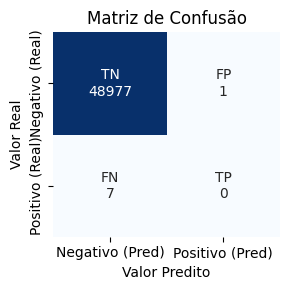

In [26]:
cm = confusion_matrix(y_test, y_pred_custom)
labels = ["TN", "FP", "FN", "TP"]
counts = [f"{label}\n{value}" for label, value in zip(labels, cm.flatten())]
counts = np.array(counts).reshape(2, 2)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=counts, fmt='', cmap="Blues", cbar=False,
            xticklabels=['Negativo (Pred)', 'Positivo (Pred)'],
            yticklabels=['Negativo (Real)', 'Positivo (Real)'])
plt.title("Matriz de Confusão", fontsize=12)
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

In [27]:
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48978
           1       0.00      0.00      0.00         7

    accuracy                           1.00     48985
   macro avg       0.50      0.50      0.50     48985
weighted avg       1.00      1.00      1.00     48985



- feature importance do modelo

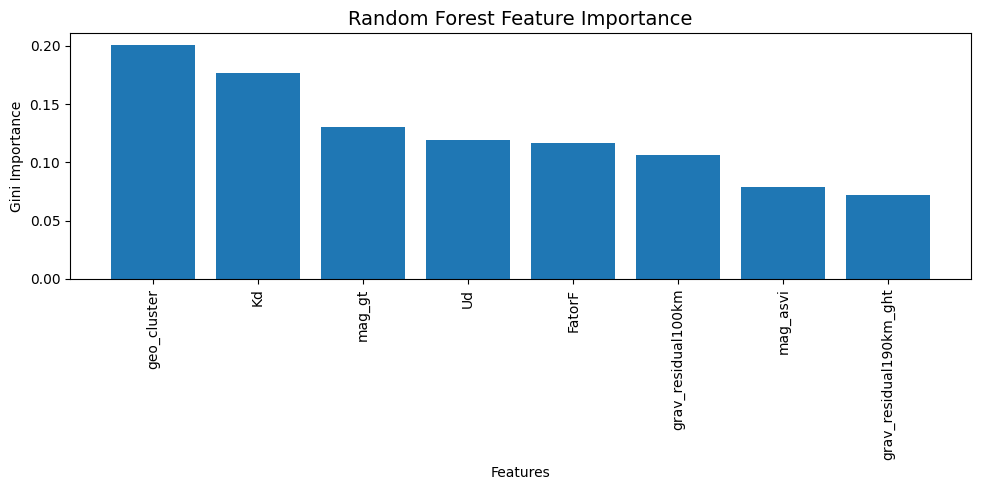

In [28]:
rf_model = pipeline.named_steps['randomforestclassifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

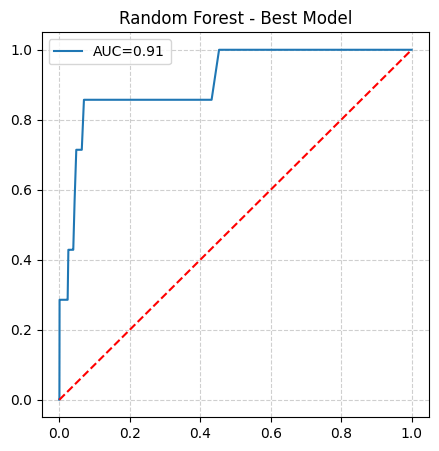

In [29]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title('Random Forest - Best Model')
ax.grid(visible=True, alpha=0.6, linestyle='--')
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

Resampled data shape: (34, 8)
All SHAP values shape: (34, 8, 2)
SHAP values for class 1: (34, 8)


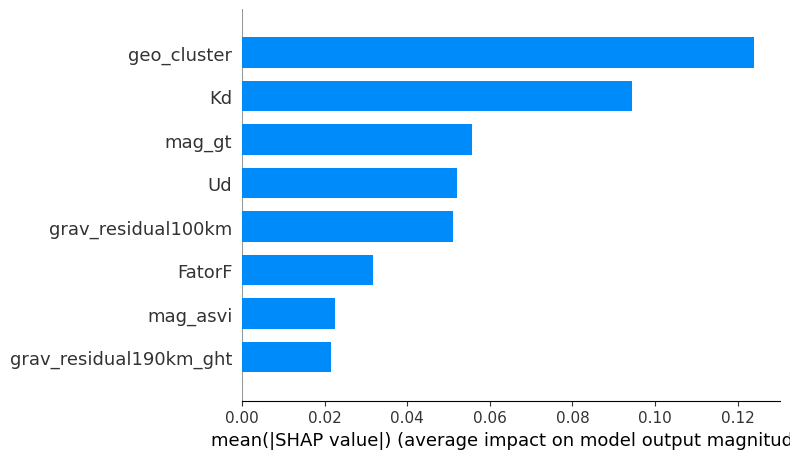

In [30]:
undersampler = pipeline.named_steps['randomundersampler']
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

model = pipeline.named_steps['randomforestclassifier']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_resampled)

print(f"Resampled data shape: {X_resampled.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values[:,:,1].shape}")

shap.summary_plot(
    shap_values[:, :, 1],
    pd.DataFrame(X_resampled, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

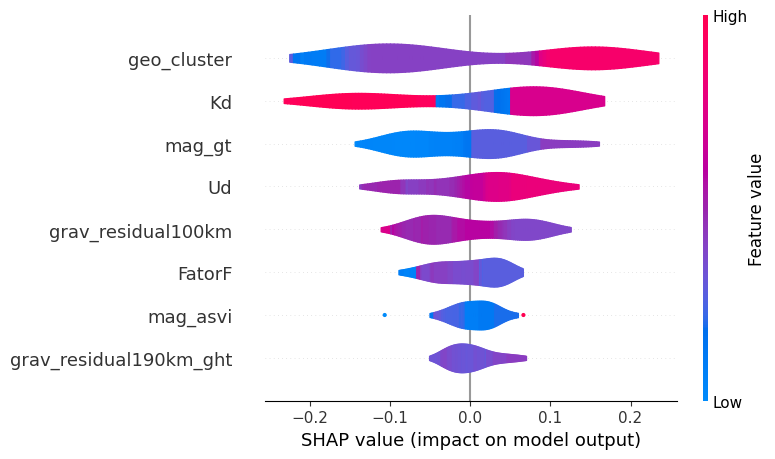

In [31]:
shap.summary_plot(
    shap_values[:, :, 1], pd.DataFrame(X_resampled, columns=X_train.columns), plot_type="violin"
)

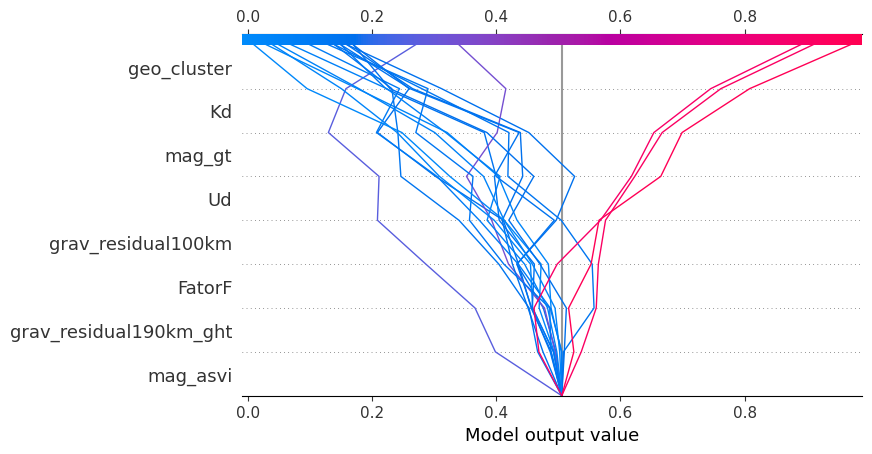

In [32]:
shap.decision_plot(
    explainer.expected_value[1], shap_values[:, :, 1][:20], feature_names=X_train.columns.tolist()
)

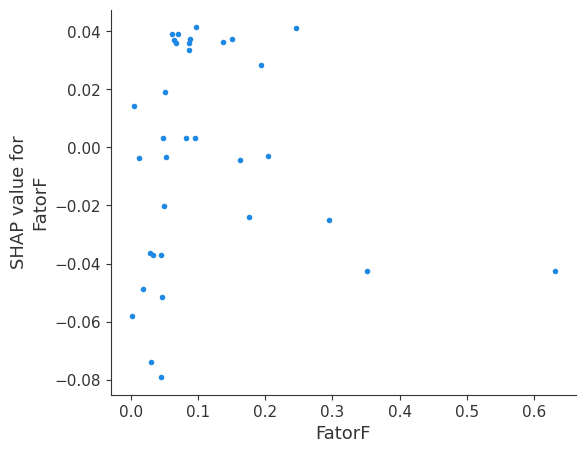

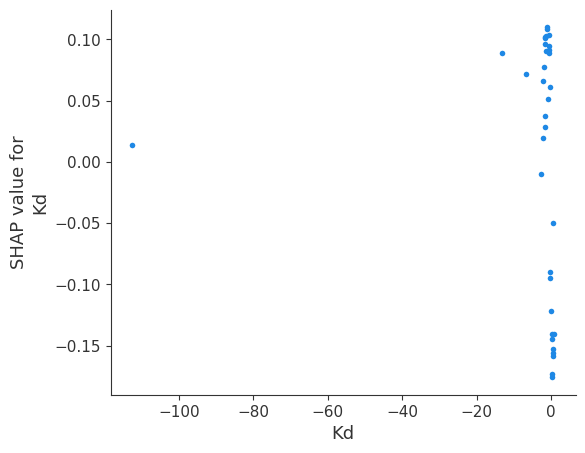

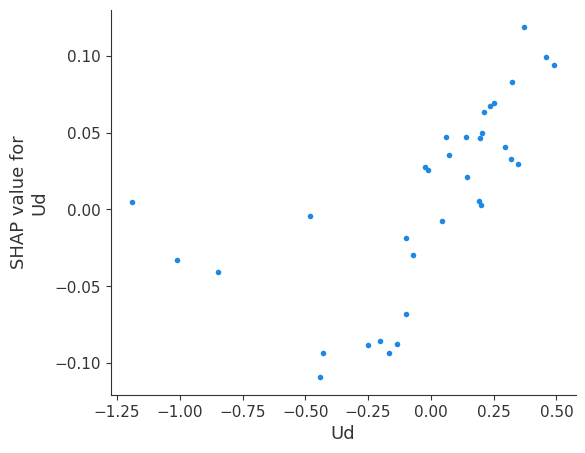

In [33]:
for feature in X_train.columns[:3]:  # Top 3 features
    shap.dependence_plot(
        feature,
        shap_values[:, :, 1],
        pd.DataFrame(X_resampled, columns=X_train.columns),
        interaction_index=None,
    )

### Mapa

In [34]:
coord_df = pd.DataFrame.from_dict(dict_map_idx_lon, orient='index')
coord_df['latitude'] = dict_map_idx_lat
coord_df.columns = ['longitude', 'latitude']
coord_df.head(3)

,longitude,latitude
0,-51.420,-8.117
1,-51.414,-8.117
2,-51.407,-8.117


In [35]:
results = X_test.copy()
results['probability'] = y_proba
results['prediction'] = y_pred_custom
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,geo_cluster,probability,prediction
52177,0.207354,0.524602,-0.118351,0.000808,6.619606,49.605854,0.008304,6,0.11,0
51772,0.168745,0.151600,-0.281629,0.000488,3.680273,47.174297,0.003959,6,0.06,0
136469,0.005500,-8.132790,-0.208064,0.000138,-1.036816,51.277111,0.005710,3,0.30,0


In [36]:
results = pd.merge(results, coord_df, left_index=True, right_index=True, how='inner')
results.head(3)

,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,geo_cluster,probability,prediction,longitude,latitude
52177,0.207354,0.524602,-0.118351,0.000808,6.619606,49.605854,0.008304,6,0.11,0,-50.761,-7.079
51772,0.168745,0.151600,-0.281629,0.000488,3.680273,47.174297,0.003959,6,0.06,0,-50.822,-7.086
136469,0.005500,-8.132790,-0.208064,0.000138,-1.036816,51.277111,0.005710,3,0.30,0,-49.854,-5.423


In [37]:
mineral_locations = results[results['prediction'] == 1]
print(f"Locais com alta confiança de ouro: {len(mineral_locations)}")

Locais com alta confiança de ouro: 1


In [38]:
# Optimal Decision Threshold: 0.990
mineral_locations_thresh = results[results['prediction'] >= 0.990]
print(f"Locais com alta confiança de ouro: {len(mineral_locations_thresh)}")

Locais com alta confiança de ouro: 1


In [39]:
# https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
fig = Figure(width=700, height=600)

m = folium.Map(
    location=[mineral_locations["latitude"].mean(), mineral_locations["longitude"].mean()],
    zoom_start=7,
)

for _, row in df_minas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="red", fill=True, tooltip="Mina"
    ).add_to(m)


for _, row in df_minerio.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="orange", fill=True, tooltip="Ouro"
    ).add_to(m)


for _, row in mineral_locations.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="yellow",
        fill=True,
        tooltip=f"Ouro Prob: {row['probability']:.3f}",
    ).add_to(m)


fig.add_child(m)